In [78]:
import numpy
import QuantLib
import matplotlib
import matplotlib.pyplot
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import pandas
from datetime import date
from typing import Union

matplotlib.pyplot.style.use('ggplot')
matplotlib.pyplot.rc('figure', figsize=(15, 6))
matplotlib.rcParams['figure.dpi'] = 150

In [79]:
day_count = QuantLib.Actual360()                             
calendar = QuantLib.UnitedStates(QuantLib.UnitedStates.NYSE)       
rolling = QuantLib.Following
payment_lag = 2


value_date = QuantLib.Date(31, 1, 2022)
start_date = calendar.advance(value_date, QuantLib.Period(2, QuantLib.Days))


SOFRCalibrationSet = pandas.read_excel('Part2.xlsx', usecols=[1, 2]).drop(
    range(5)
).reset_index(drop=True)
SOFRCalibrationSet.columns = ["Dates", "Rates"]
Libor3MCalibrationSet = pandas.read_excel('Part2.xlsx', usecols=[11, 12]).drop(
    range(5)
).dropna().reset_index(drop=True)
Libor3MCalibrationSet.columns = ["Dates", "Rates"]
Libor6MCalibrationSet = pandas.read_excel('Part2.xlsx', usecols=[19, 20]).drop(
    range(5)
).dropna().reset_index(drop=True)
Libor6MCalibrationSet.columns = ["Dates", "Rates"]

1) Build SOFR curve using OIS market quotes


$$PV^{ois} = \sum_{i = 1} ^{n} P_d (0, \hat T_i)\left[\tau_i\left(\frac{1}{\tau_i} \left[\frac{P_d(0, T_{i-1})}{P_d(0, T_{i})} - 1\right] - K\right)\right]= \sum_{i = 1} ^{n} P_d (0, \hat T_i)\left[\left(\frac{P_d(0, T_{i-1})}{P_d(0, T_{i})} - 1\right) - \tau_iK\right].$$

In [80]:
def getPillarDatesSOFR(data):
    start_dates = []
    end_dates = []
    pay_dates = []
    frequency = 0
    
    period_str = data.replace('SOFR_','')
        
    if 'M' in period_str:
        frequency = 1
        period = int(period_str.replace('M',''))
        start_dates.append(start_date)
        end_dates.append(calendar.advance(start_date, QuantLib.Period(period, QuantLib.Months), rolling))
        pay_dates.append(calendar.advance(end_dates[0], QuantLib.Period(2, QuantLib.Days)))
    else:
        frequency = int(period_str.replace('Y',''))
        period = int(period_str.replace('Y',''))
        for i in range(period):
            start_dates.append(calendar.advance(start_date, QuantLib.Period(i, QuantLib.Years)))
            end_dates.append(calendar.advance(start_dates[i], QuantLib.Period(1, QuantLib.Years), rolling))
            pay_dates.append(calendar.advance(end_dates[i], QuantLib.Period(2, QuantLib.Days)))

    return start_dates, end_dates, pay_dates, frequency
    

In [81]:
def getPriceOIS (x, start_dates, end_dates, pay_dates, frequency, quote, all_tau_pays, DF_d_disc):
    result = 0
    tau_i = 0
    tau_pay = 0
    tau_start = 0
    tau_end = 0
    DF = DF_d_disc
    DF[-1] = x[0]
    fun = interp1d(all_tau_pays, np.log(DF), kind = 'linear')
    for i in range(frequency):
        tau_i = day_count.yearFraction(start_dates[i], end_dates[i])
        tau_pay = day_count.yearFraction(value_date, pay_dates[i])
        tau_start = day_count.yearFraction(value_date, start_dates[i])
        tau_end = day_count.yearFraction(value_date, end_dates[i])
        result += np.exp(fun(tau_pay)) * (( np.exp(fun(tau_start))/np.exp(fun(tau_end)) - 1) - tau_i * quote)
    return result

In [82]:
start_dates = []
end_dates = []
pay_dates = []
frequency = []

all_tau_pays = [0]
DF_d_disc = [1]

for i in range(len(SOFRCalibrationSet)):
    start_dates, end_dates, pay_dates, frequency = getPillarDatesSOFR(SOFRCalibrationSet['Dates'][i])
    all_tau_pays.append(day_count.yearFraction(value_date, pay_dates[-1]))
    DF_d_disc.append(0)
    res = fsolve(getPriceOIS, DF_d_disc[-2], args=(start_dates, end_dates, pay_dates, frequency, SOFRCalibrationSet['Rates'][i]/100, all_tau_pays, DF_d_disc))[0]
log_P_d = interp1d(all_tau_pays, np.log(DF_d_disc), kind = 'linear') 


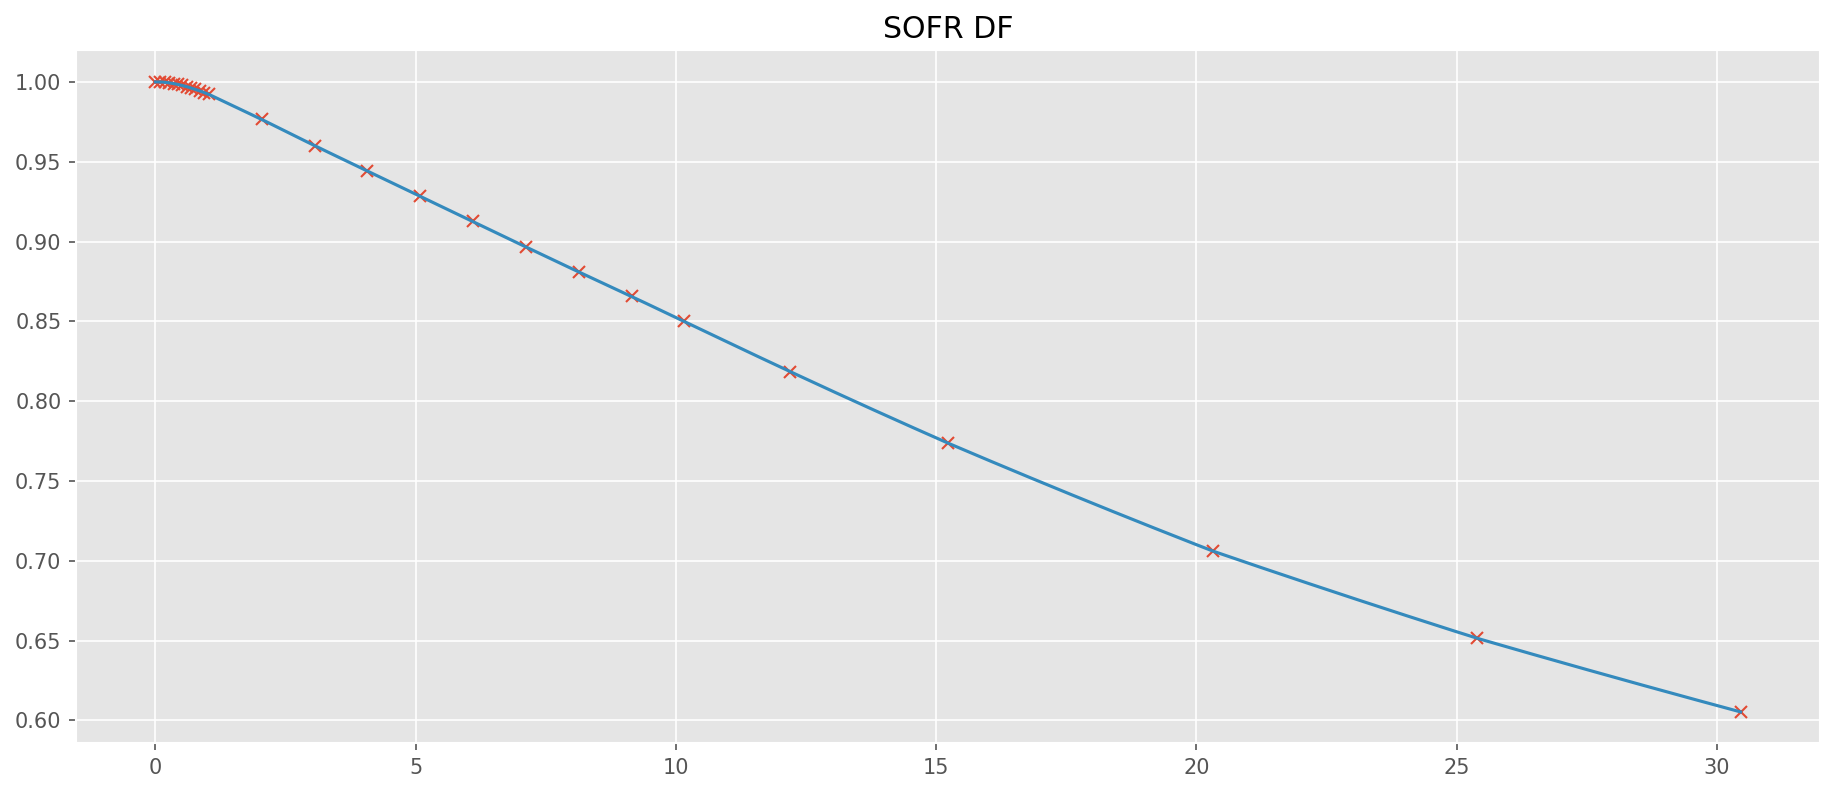

In [83]:
inter_tau = np.linspace(0, all_tau_pays[-1], 2000)
inter_DF = np.exp(log_P_d(inter_tau))

_, axis = matplotlib.pyplot.subplots()
axis.plot(
    all_tau_pays,
    DF_d_disc,
    'x'
)
axis.plot(
    inter_tau,
    inter_DF
)

matplotlib.pyplot.title("SOFR DF")
matplotlib.pyplot.xlabel('')
matplotlib.pyplot.show()

2) Build 3M LIBOR curve using SOFR as discounting curve

2.1) Deposit

$$F(0, T_{start}, T_{end}) = K,$$
$$\frac{1}{\tau} \left[\frac{P^{\tau}_f(0, T_{start})}{P^{\tau}_f(0, T_{end})} - 1\right] = K.$$

In [84]:
DF_f_3M = [1]
all_tau_pays_f_3M = [0]
start_dates_f_3M = [start_date]
end_dates_f_3M = [calendar.advance(start_date, QuantLib.Period(3, QuantLib.Months), rolling)]
all_tau_pays_f_3M.append(day_count.yearFraction(value_date, end_dates_f_3M[-1]))
DF_f_3M.append(0)
fsolve(getPriceOIS, DF_f_3M[-2], args=(start_dates_f_3M, end_dates_f_3M, end_dates_f_3M, 1, Libor3MCalibrationSet['Rates'][0]/100, all_tau_pays_f_3M, DF_f_3M))[0]

np.float64(0.9992422349920532)

2.2) FRA

$$PV^{FRA} = B^d_0 \ \mathbb E^{\mathbb Q^d} \left[\frac{(L(T_{start}, T_{end}) - K) \tau}{1 + \tau L(T_{start}, T_{end})} * \frac{1}{B_{T_{start}}^d}\right],$$

$$\frac{1}{P^{\tau}_f(T_{start}, T_{end})} = 1 + \tau L(T_{start}, T_{end}),$$

$$PV^{FRA} = B^d_0 \ \mathbb E^{\mathbb Q^d} \left[\frac{1 - (1 + K\tau) P^{\tau}_f(T_{start}, T_{end})}{B_{T_{start}}^d}\right] = P_d(0, T_{start}) - (1 + K\tau)P^{\tau}_f(0, T_{end}),$$

$$P^{\tau}_f(0, T_{end}) = \frac{P_d(0, T_{start})}{1 + K\tau}$$

In [85]:
start_dates_f_3M.append(calendar.advance(start_date, QuantLib.Period(3, QuantLib.Months)))
start_dates_f_3M.append(calendar.advance(start_date, QuantLib.Period(6, QuantLib.Months)))
end_dates_f_3M.append(calendar.advance(start_dates_f_3M[1], QuantLib.Period(3, QuantLib.Months), rolling))
end_dates_f_3M.append(calendar.advance(start_dates_f_3M[2], QuantLib.Period(3, QuantLib.Months), rolling))

In [86]:
all_tau_pays_f_3M.append(day_count.yearFraction(value_date, end_dates_f_3M[1]))
all_tau_pays_f_3M.append(day_count.yearFraction(value_date, end_dates_f_3M[2]))

In [89]:
DF_f_3M.append(np.exp(log_P_d(day_count.yearFraction(value_date, start_dates_f_3M[1])))\
                /(1 + Libor3MCalibrationSet['Rates'][1]/100 * day_count.yearFraction(start_dates_f_3M[1], end_dates_f_3M[1])))
DF_f_3M.append(np.exp(log_P_d(day_count.yearFraction(value_date, start_dates_f_3M[2])))\
                /(1 + Libor3MCalibrationSet['Rates'][2]/100 * day_count.yearFraction(start_dates_f_3M[2], end_dates_f_3M[2])))

2.3) IRS


$$PV^{IRS} = \sum_{i = 1} ^{n} P_d (0, T_i)\mathbb E^{T_i^d}\tau_iL(T_{i-1}, T_i) - \sum_{i = 1} ^{m} P_d (0, \bar T_i)\tau_i K$$
$$\approx \sum_{i = 1} ^{n} P_d (0, T_i)\tau_i\tilde F(0, T_{i-1}, T_i) - \sum_{i = 1} ^{m} P_d (0, \bar T_i)\tau_i K = \sum_{i = 1} ^{n} P_d (0, T_i)(\frac{P^{\tau}_f(0, T_{i-1})}{P^{\tau}_f(0, T_{i})} - 1) - \sum_{i = 1} ^{m} P_d (0, \bar T_i)\tau_i K.$$


In [90]:
def schedule_3M_Libor(data):
    start_dates_float = []
    end_dates_float = []
    start_dates_fix = []
    end_dates_fix = []
    
    period_str = data.replace('USD_','').replace('_3M_LIBOR_1Y_FIX', '')
    
    year = int(period_str.replace('Y',''))
    
    for i in range(4 * year):
        start_dates_float.append(calendar.advance(start_date, QuantLib.Period(3 * i, QuantLib.Months)))
        end_dates_float.append(calendar.advance(start_dates_float[i], QuantLib.Period(3, QuantLib.Months), rolling))
    for i in range(year):
        start_dates_fix.append(calendar.advance(start_date, QuantLib.Period(i, QuantLib.Years)))
        end_dates_fix.append(calendar.advance(start_dates_fix[i], QuantLib.Period(1, QuantLib.Years), rolling))   

    return start_dates_float, end_dates_float, start_dates_fix, end_dates_fix, 4 * year, year

In [91]:
def getPriceIRS (x, start_dates_float, end_dates_float, start_dates_fix, end_dates_fix, frequency_float, frequency_fix, quote, all_tau_pays, DF):
    result = 0
    tau_i = 0
    tau_start = 0
    tau_end = 0
    DF[-1] = x[0]
    
    fun = interp1d(all_tau_pays, np.log(DF), kind = 'linear')
    for i in range(frequency_float):
        tau_start = day_count.yearFraction(value_date, start_dates_float[i])
        tau_end = day_count.yearFraction(value_date, end_dates_float[i])
        result += np.exp(log_P_d(tau_end)) * ( np.exp(fun(tau_start))/np.exp(fun(tau_end)) - 1)
    for i in range(frequency_fix):
        tau_i = day_count.yearFraction(start_dates_fix[i], end_dates_fix[i])
        tau_end = day_count.yearFraction(value_date, end_dates_fix[i])
        result -= np.exp(log_P_d(tau_end)) * quote * tau_i
    return result

In [93]:
start_dates_float = []
end_dates_float = []
start_dates_fix = []
end_dates_fix = []

for i in range(3, len(Libor3MCalibrationSet)):
    start_dates_float, end_dates_float, start_dates_fix, end_dates_fix, frequency_float, frequency_fix = schedule_3M_Libor(Libor3MCalibrationSet['Dates'][i])
    all_tau_pays_f_3M.append(day_count.yearFraction(value_date, end_dates_float[-1]))
    DF_f_3M.append(0)
    fsolve(getPriceIRS, DF_f_3M[-2], args=(start_dates_float, end_dates_float, start_dates_fix, end_dates_fix, frequency_float, frequency_fix, Libor3MCalibrationSet['Rates'][i]/100, all_tau_pays_f_3M, DF_f_3M))

log_P_f_3M = interp1d(all_tau_pays_f_3M, np.log(DF_f_3M), kind = 'linear') 


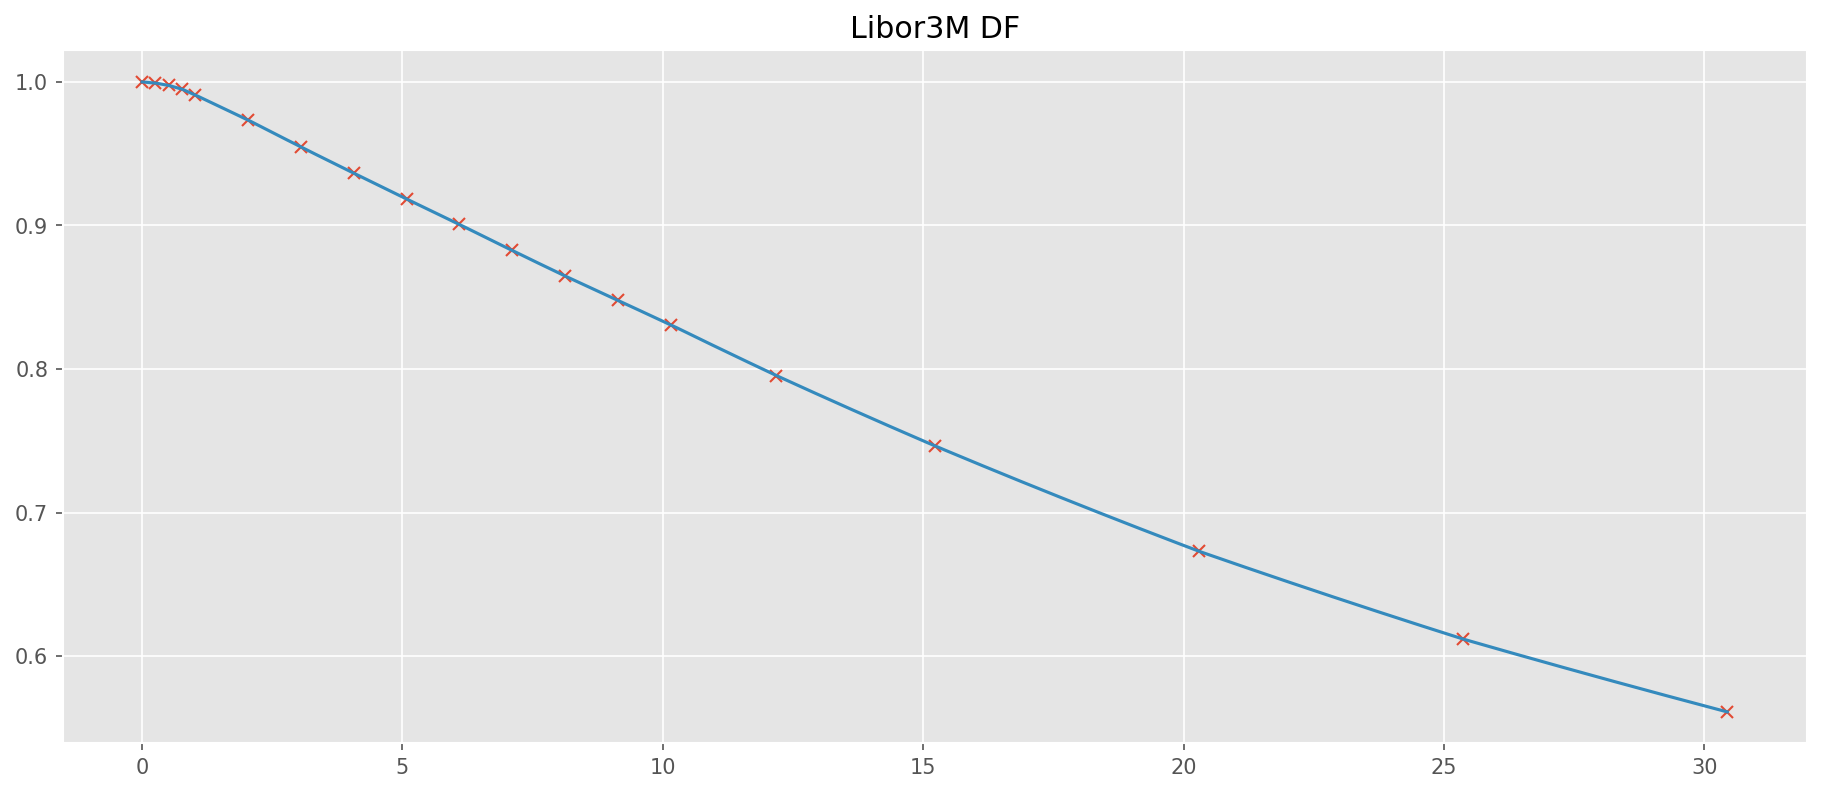

In [94]:
inter_tau = np.linspace(0, all_tau_pays_f_3M[-1], 2000)
inter_DF = np.exp(log_P_f_3M(inter_tau))

_, axis = matplotlib.pyplot.subplots()
axis.plot(
    all_tau_pays_f_3M,
    DF_f_3M,
    'x'
)
axis.plot(
    inter_tau,
    inter_DF
)

matplotlib.pyplot.title("Libor3M DF")
matplotlib.pyplot.xlabel('')
matplotlib.pyplot.show()

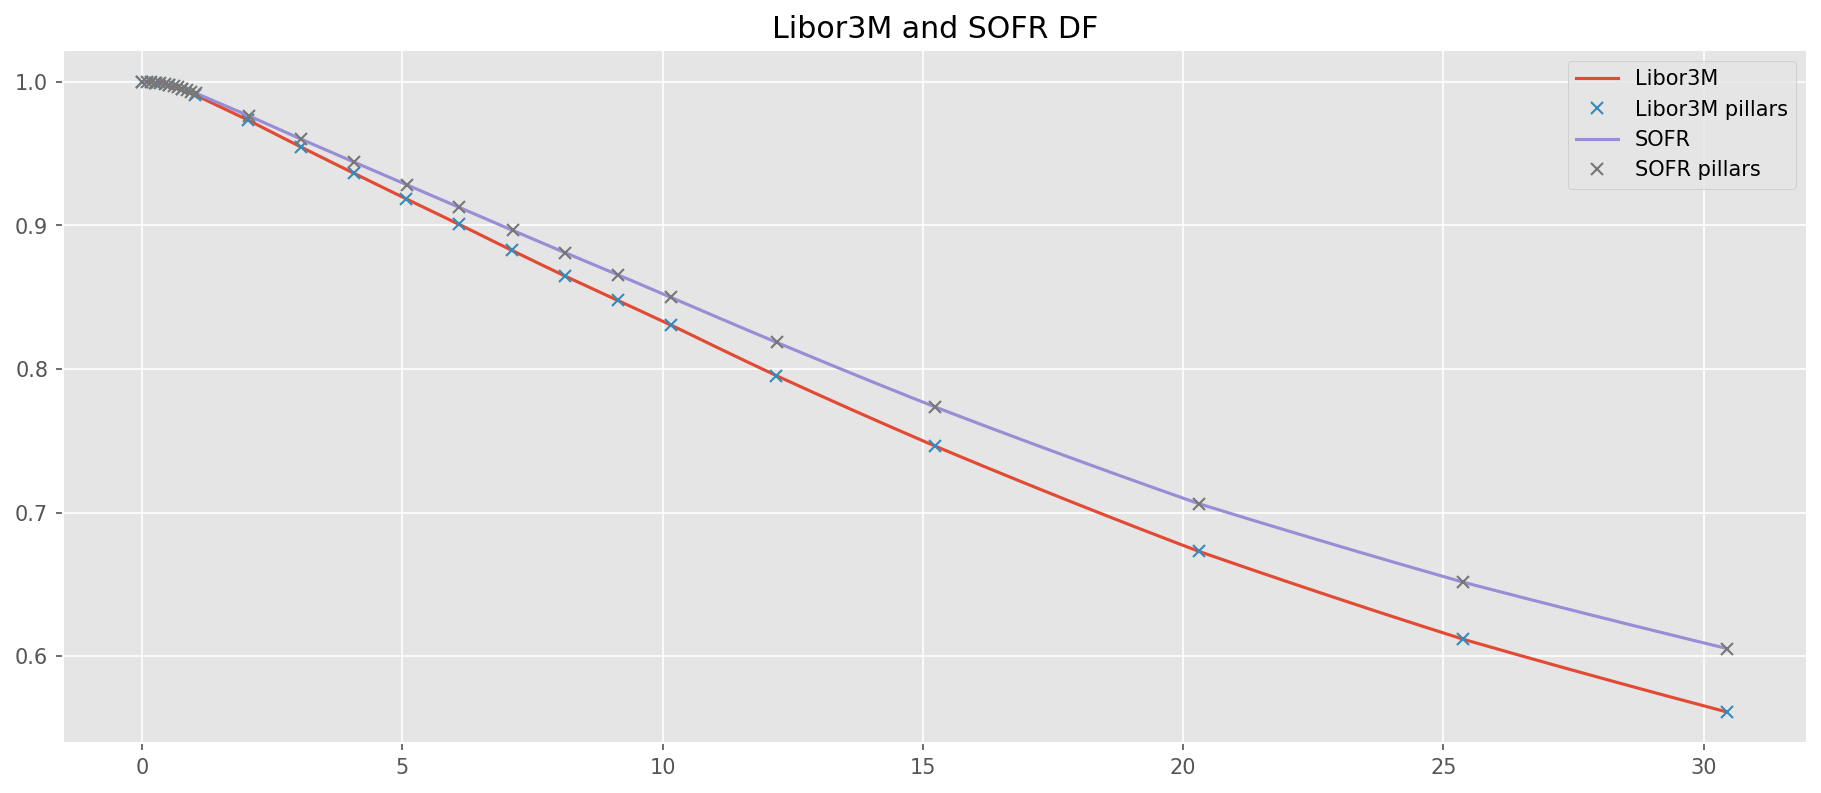

In [95]:
inter_tau = np.linspace(0, all_tau_pays_f_3M[-1], 2000)
inter_DF = np.exp(log_P_f_3M(inter_tau))

_, axis = matplotlib.pyplot.subplots()
axis.plot(
    inter_tau,
    inter_DF
)
axis.plot(
    all_tau_pays_f_3M,
    DF_f_3M,
    'x'
)
axis.plot(
    inter_tau,
    np.exp(log_P_d(inter_tau))
)
axis.plot(
    all_tau_pays,
    DF_d_disc,
    'x'
)
axis.legend(["Libor3M", "Libor3M pillars", "SOFR", "SOFR pillars"])
matplotlib.pyplot.title("Libor3M and SOFR DF")
matplotlib.pyplot.xlabel('')
matplotlib.pyplot.show()

3) Using SOFR and 3M LIBOR curves, build 6M LIBOR curve

3.1) Deposit

$$F(0, \hat T_{start}, \hat T_{end}) = K,$$
$$\frac{1}{\hat \tau} \left[\frac{P^{\hat\tau}_f(0, \hat T_{start})}{P^{\hat\tau}_f(0, \hat T_{end})} - 1\right] = K.$$

In [97]:
DF_f_6M = [1]
all_tau_pays_f_6M = [0]
start_dates_f_6M = [start_date]
end_dates_f_6M = [calendar.advance(start_date, QuantLib.Period(6, QuantLib.Months), rolling)]
all_tau_pays_f_6M.append(day_count.yearFraction(value_date, end_dates_f_3M[-1]))
DF_f_6M.append(0)
fsolve(getPriceOIS, DF_f_6M[-2], args=(start_dates_f_6M, end_dates_f_6M, end_dates_f_6M, 1, Libor6MCalibrationSet['Rates'][0]/100, all_tau_pays_f_6M, DF_f_6M))[0]


np.float64(0.9958131986218068)

3.2) Basis swap

$$PV^{bswap} = PV^{float\_3M} - PV^{float\_6M},$$

$$PV^{float\_3M} \approx \sum_{i = 1} ^{n} P_d (0, T_i)\tau_i\left[\tilde F(0, T_{i-1}, T_i) + s\right] = \sum_{i = 1} ^{n} P_d (0, T_i)\left[(\frac{P^{\tau}_f(0, T_{i-1})}{P^{\tau}_f(0, T_{i})} - 1) + \tau_i s\right],$$

$$PV^{float\_6M} \approx \sum_{i = 1} ^{m} P_d (0, \hat T_i)\hat\tau_i\tilde F(0, \hat T_{i-1}, \hat T_i) = \sum_{i = 1} ^{m} P_d (0, \hat T_i)(\frac{P^{\hat\tau}_f(0, \hat T_{i-1})}{P^{\hat\tau}_f(0, \hat T_{i})} - 1). $$

In [98]:
def getPillarDatesLibor6M(data):
    start_dates_3M = []
    end_dates_3M = []
    start_dates_6M = []
    end_dates_6M = []
    
    period_str = data.replace('USD_','').replace('_3M_LIBOR_Plus_Spread_6M_LIBOR', '')
    
    if 'M' in period_str:
        year = 1.5
    else:
        year = int(period_str.replace('Y',''))
    
    for i in range(int(4 * year)):
        start_dates_3M.append(calendar.advance(start_date, QuantLib.Period(3 * i, QuantLib.Months)))
        end_dates_3M.append(calendar.advance(start_dates_3M[i], QuantLib.Period(3, QuantLib.Months), rolling))
    for i in range(int(2 * year)):
        start_dates_6M.append(calendar.advance(start_date, QuantLib.Period(6 * i, QuantLib.Months)))
        end_dates_6M.append(calendar.advance(start_dates_6M[i], QuantLib.Period(6, QuantLib.Months), rolling))   

    return start_dates_3M, end_dates_3M, start_dates_6M, end_dates_6M, int(4 * year), int(2 * year)

In [99]:
def getPriceBasisSwap (x, start_dates_3M, end_dates_3M, start_dates_6M, end_dates_6M, frequency_3M, frequency_6M, quote, all_tau_pays, DF):
    result = 0
    tau_i = 0
    tau_start = 0
    tau_end = 0
    DF[-1] = x[0]
    fun = interp1d(all_tau_pays, np.log(DF), kind = 'linear')
    for i in range(frequency_3M):
        tau_i = day_count.yearFraction(start_dates_3M[i], end_dates_3M[i])
        tau_start = day_count.yearFraction(value_date, start_dates_3M[i])
        tau_end = day_count.yearFraction(value_date, end_dates_3M[i])
        result += np.exp(log_P_d(tau_end)) * ( np.exp(log_P_f_3M(tau_start))/np.exp(log_P_f_3M(tau_end)) - 1 + tau_i * quote)
    for i in range(frequency_6M):
        tau_start = day_count.yearFraction(value_date, start_dates_6M[i])
        tau_end = day_count.yearFraction(value_date, end_dates_6M[i])
        result += - np.exp(log_P_d(tau_end)) * ( np.exp(fun(tau_start))/np.exp(fun(tau_end)) - 1)
    return result

In [100]:
start_dates_3M = []
end_dates_3M = []
start_dates_6M = []
end_dates_6M = []

for i in range(1, len(Libor6MCalibrationSet)):
    start_dates_3M, end_dates_3M, start_dates_6M, end_dates_6M, frequency_3M, frequency_6M = getPillarDatesLibor6M(Libor6MCalibrationSet['Dates'][i])
    all_tau_pays_f_6M.append(day_count.yearFraction(value_date, end_dates_6M[-1]))
    DF_f_6M.append(0)
    res = fsolve(getPriceBasisSwap, DF_f_6M[-2], args=(start_dates_3M, end_dates_3M, start_dates_6M, end_dates_6M, frequency_3M, frequency_6M, Libor6MCalibrationSet['Rates'][i]/10000, all_tau_pays_f_6M, DF_f_6M))[0]

log_P_f_6M = interp1d(all_tau_pays_f_6M, np.log(DF_f_6M), kind = 'linear') 

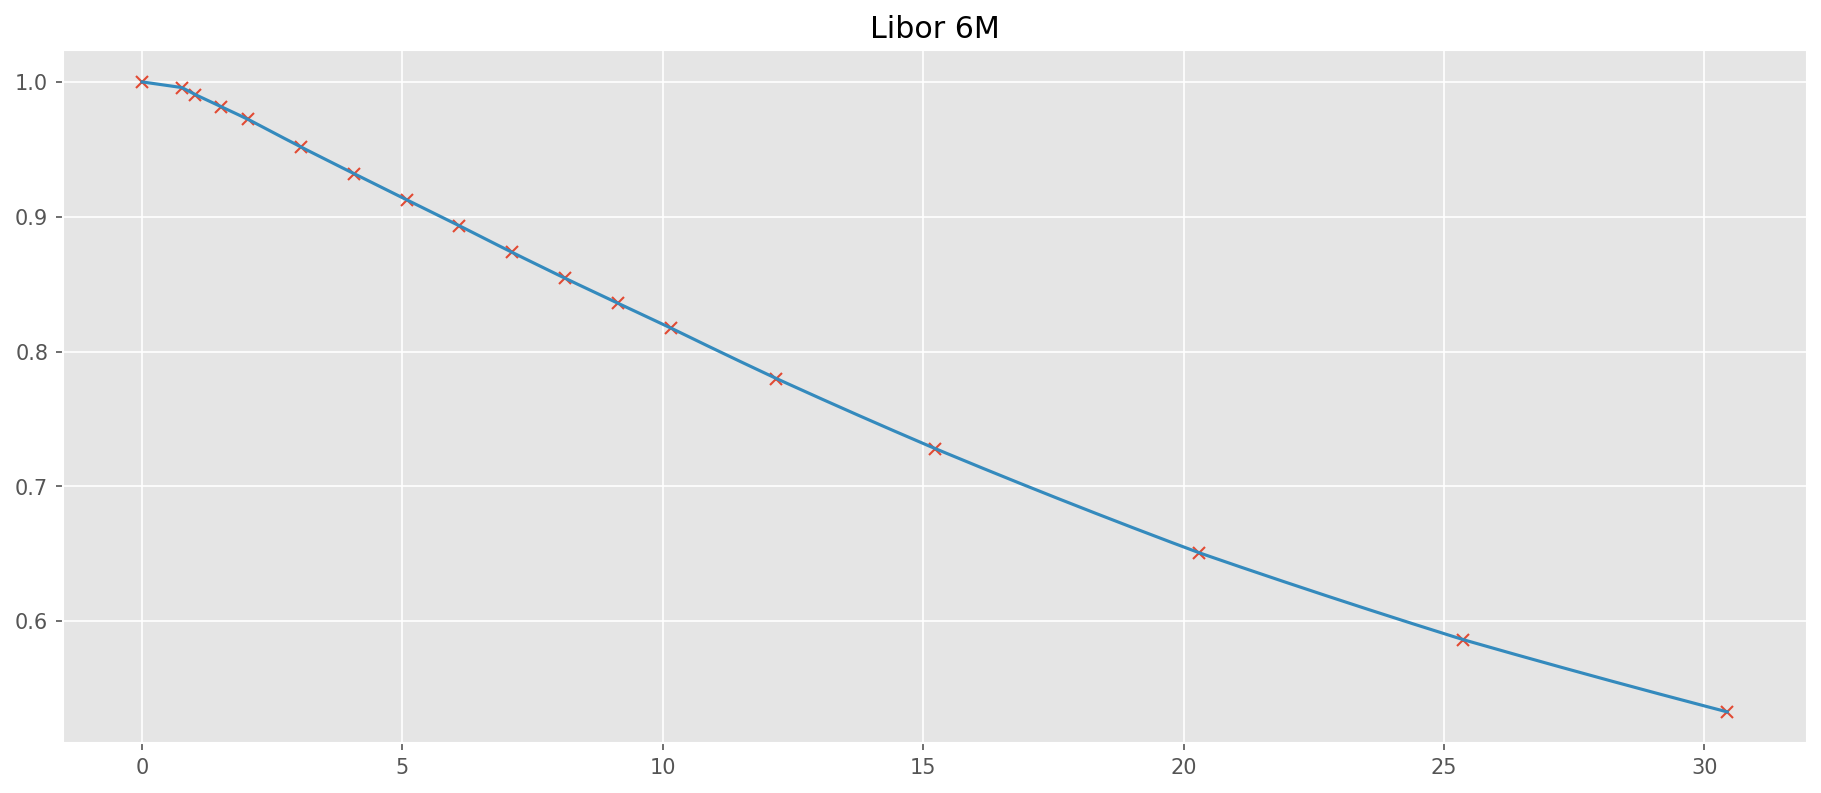

In [101]:
inter_tau = np.linspace(0, all_tau_pays_f_6M[-1], 2000)
inter_DF = np.exp(log_P_f_6M(inter_tau))

_, axis = matplotlib.pyplot.subplots()
axis.plot(
    all_tau_pays_f_6M,
    DF_f_6M,
    'x'
)
axis.plot(
    inter_tau,
    inter_DF
)

matplotlib.pyplot.title("Libor 6M")
matplotlib.pyplot.xlabel('')
matplotlib.pyplot.show()

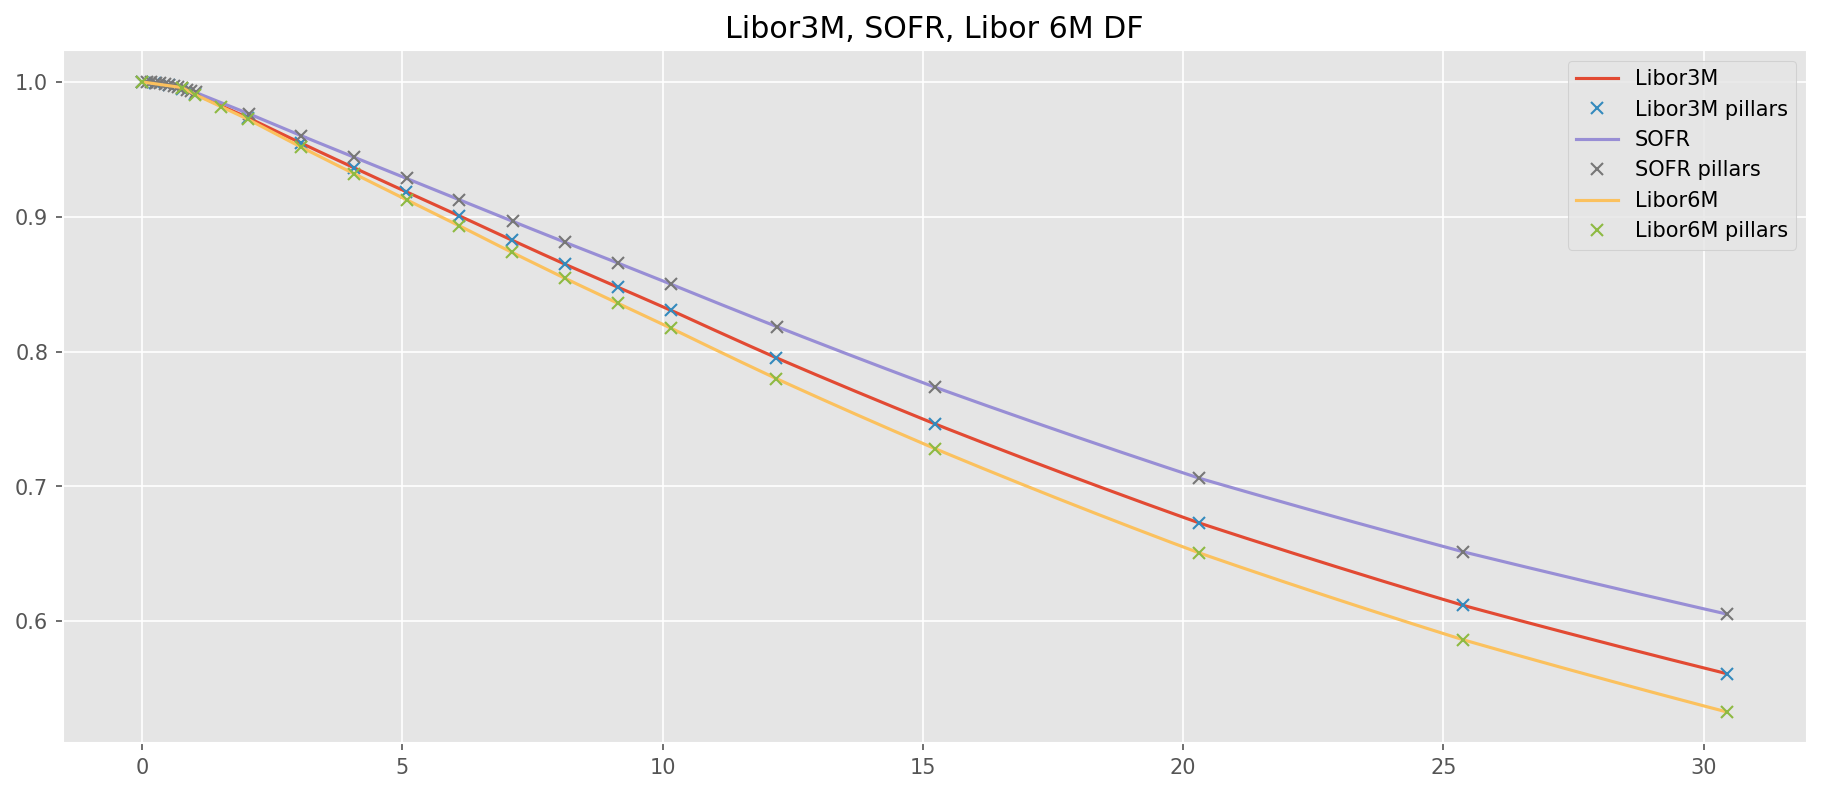

In [102]:
inter_tau = np.linspace(0, all_tau_pays_f_6M[-1], 2000)

_, axis = matplotlib.pyplot.subplots()
axis.plot(
    inter_tau,
    np.exp(log_P_f_3M(inter_tau))
)
axis.plot(
    all_tau_pays_f_3M,
    DF_f_3M,
    'x'
)
axis.plot(
    inter_tau,
    np.exp(log_P_d(inter_tau))
)
axis.plot(
    all_tau_pays,
    DF_d_disc,
    'x'
)
axis.plot(
    inter_tau,
    np.exp(log_P_f_6M(inter_tau))
)
axis.plot(
    all_tau_pays_f_6M,
    DF_f_6M,
    'x'
)

axis.legend(["Libor3M", "Libor3M pillars", "SOFR", "SOFR pillars", "Libor6M", "Libor6M pillars"])
matplotlib.pyplot.title("Libor3M, SOFR, Libor 6M DF")
matplotlib.pyplot.xlabel('')
matplotlib.pyplot.show()